In [33]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Lambda
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# visualization
import matplotlib.pyplot as plt

In [34]:
data, labels, original_labels = utility.load_data()

Dataset split: 70700 train rows
Dataset split: 70700 test rows


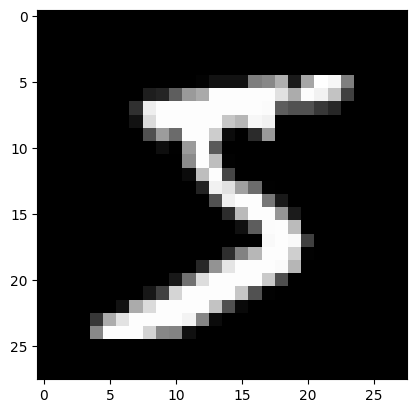

In [35]:
print(f"Dataset split: {len(data)} train rows")
print(f"Dataset split: {len(labels)} test rows")

point = data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [36]:
normal_train_data, anom_train_data, test_data, test_labels, val_data, original_test_labels = utility.preprocess_data(data, labels)

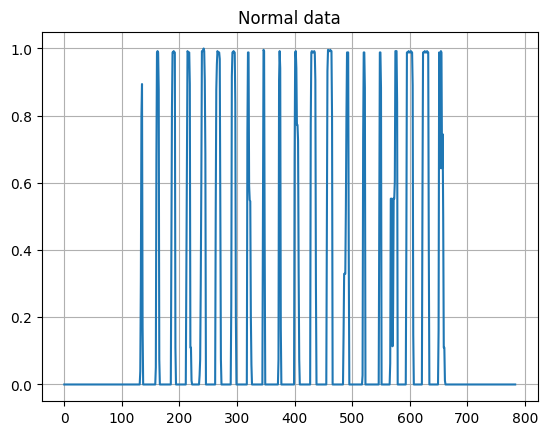

In [37]:
plt.grid()
plt.plot(np.arange(784), normal_train_data[0])
plt.title("Normal data")
plt.show()

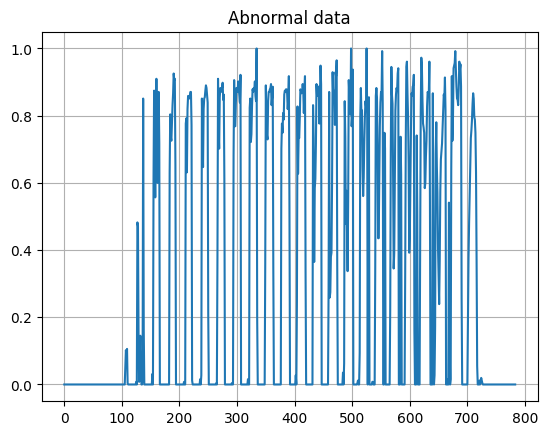

In [38]:
plt.grid()
plt.plot(np.arange(784), anom_train_data[0])
plt.title("Abnormal data")
plt.show()

In [39]:
latent_dim = 2

In [40]:
# encoder
vae_input = Input(shape=(784,))
x = Dense(256, activation='relu')(vae_input)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [41]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [42]:
z = Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [43]:
# decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_input)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(784, activation='sigmoid')(x)
decoded = x

In [44]:
# Encoder model
encoder = Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = Model(inputs=decoder_input, outputs=decoded)

In [45]:
vae_output = decoder(encoder(vae_input)[2])
vae = Model(inputs=vae_input, outputs=vae_output)

In [46]:
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
    vae_loss = reconstruction_loss + kl_loss
    return vae_loss

vae.add_loss(vae_loss(vae_input, vae_output))

In [47]:
vae.compile(optimizer='adam')

In [48]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Adding the early stopping callback to the fit method
history = vae.fit(normal_train_data, normal_train_data, epochs=100, batch_size=512, validation_data=(val_data, val_data), callbacks=[early_stopping])

Epoch 1/100


83/83 [==============================] - 2s 15ms/step - loss: 0.1767 - val_loss: 0.1548
Epoch 2/100
83/83 [==============================] - 1s 12ms/step - loss: 0.0829 - val_loss: 0.1249
Epoch 3/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0760 - val_loss: 0.0984
Epoch 4/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0732 - val_loss: 0.0828
Epoch 5/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0717 - val_loss: 0.0755
Epoch 6/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0707 - val_loss: 0.0727
Epoch 7/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0701 - val_loss: 0.0710
Epoch 8/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0696 - val_loss: 0.0703
Epoch 9/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0693 - val_loss: 0.0697
Epoch 10/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0690 - val_loss: 0.0696
Epoch 11/10

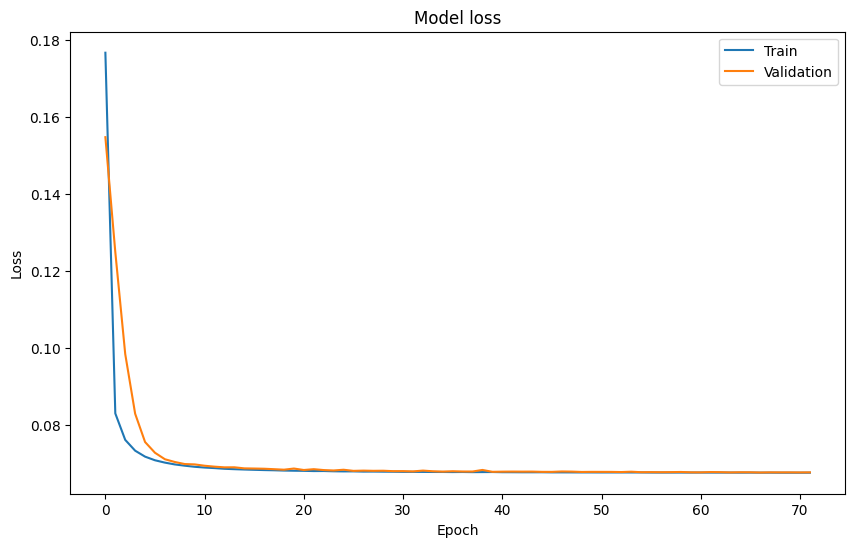

In [49]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1313/1313 [==============================] - 2s 1ms/step


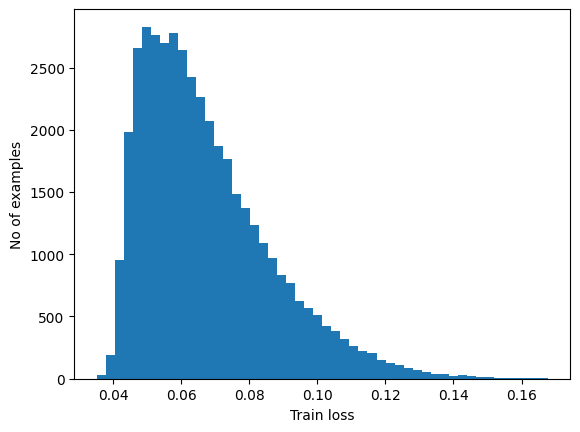

In [50]:
reconstructions = vae.predict(normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [51]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold)

# Choose a quantile (e.g., 99th percentile) for the threshold
threshold = np.percentile(train_loss, 99)
print("Quantile Threshold ", threshold)

Threshold  0.08644217
Quantile Threshold  0.12523178681731206


 1/14 [=>............................] - ETA: 0s

14/14 [==============================] - 0s 2ms/step


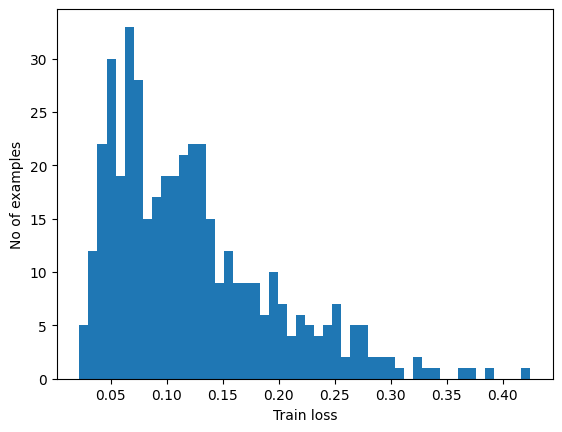

In [52]:
reconstructions = vae.predict(anom_train_data)
train_loss = tf.keras.losses.mse(reconstructions, anom_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [53]:
threshold_anom = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold_anom)

Threshold  0.19601473


In [54]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mse(reconstructions, data)
    return tf.math.less(loss, threshold), loss

In [55]:
preds, loss = predict(vae, test_data, threshold)

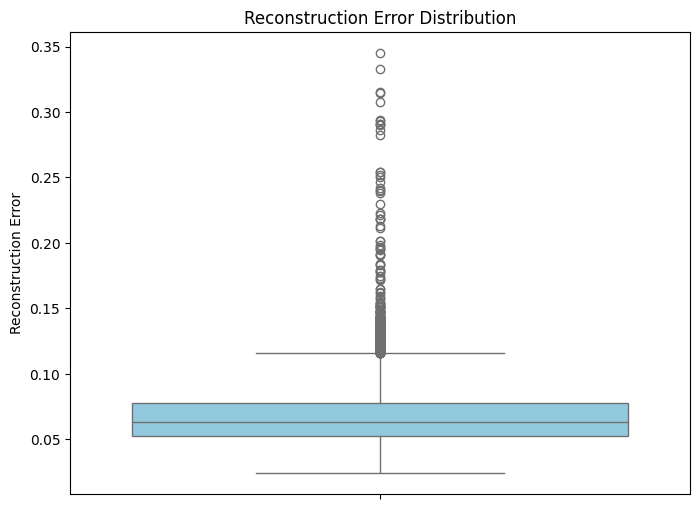

In [56]:
utility.boxplot_plot(loss)

C:\Users\zippe\AppData\Local\Temp\ipykernel_20744\1046356683.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')


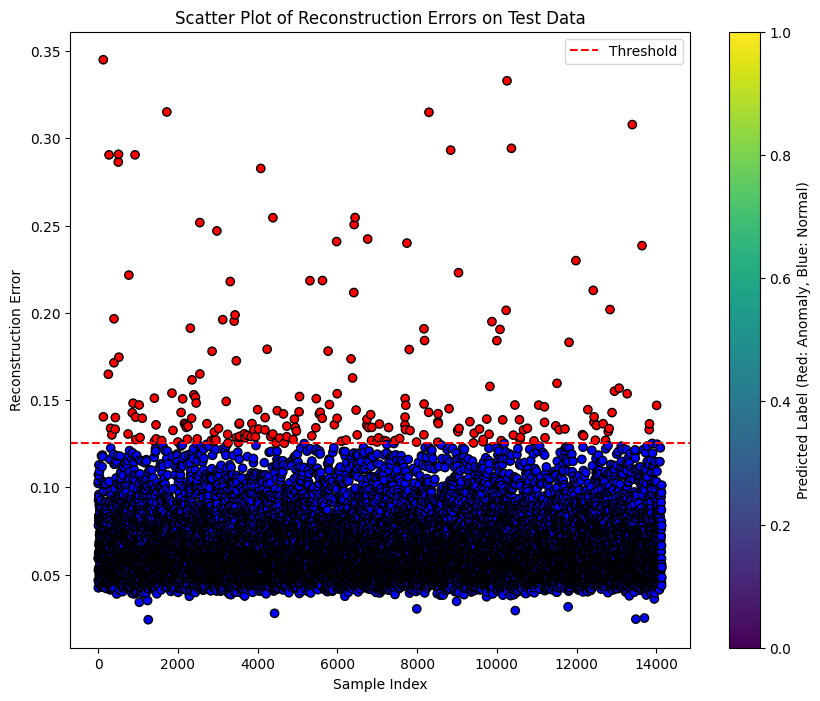

In [57]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(loss > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [58]:
a, p, r, report, cm = utility.get_metrics(preds, test_labels)

In [59]:
utility.print_stats(a, p, r, report, cm)

Accuracy = 0.9832390381895333
Precision = 0.994181452481862
Recall = 0.9888539582737925
Report
               precision    recall  f1-score   support

     anomaly       0.29      0.44      0.35       144
      normal       0.99      0.99      0.99     13996

    accuracy                           0.98     14140
   macro avg       0.64      0.71      0.67     14140
weighted avg       0.99      0.98      0.98     14140

Confusion Matrix
[[   63    81]
 [  156 13840]]


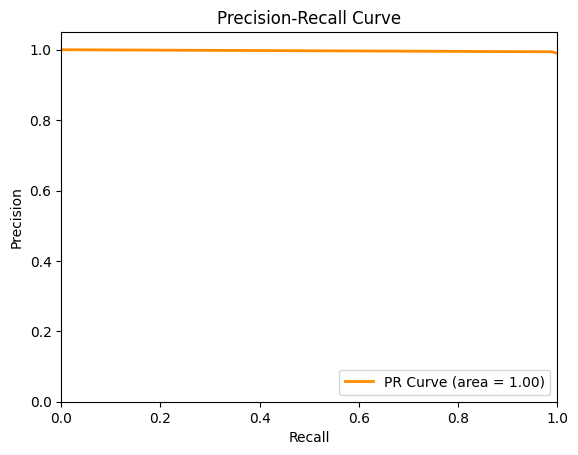

In [60]:
utility.pr_auc_plot(preds, test_labels)

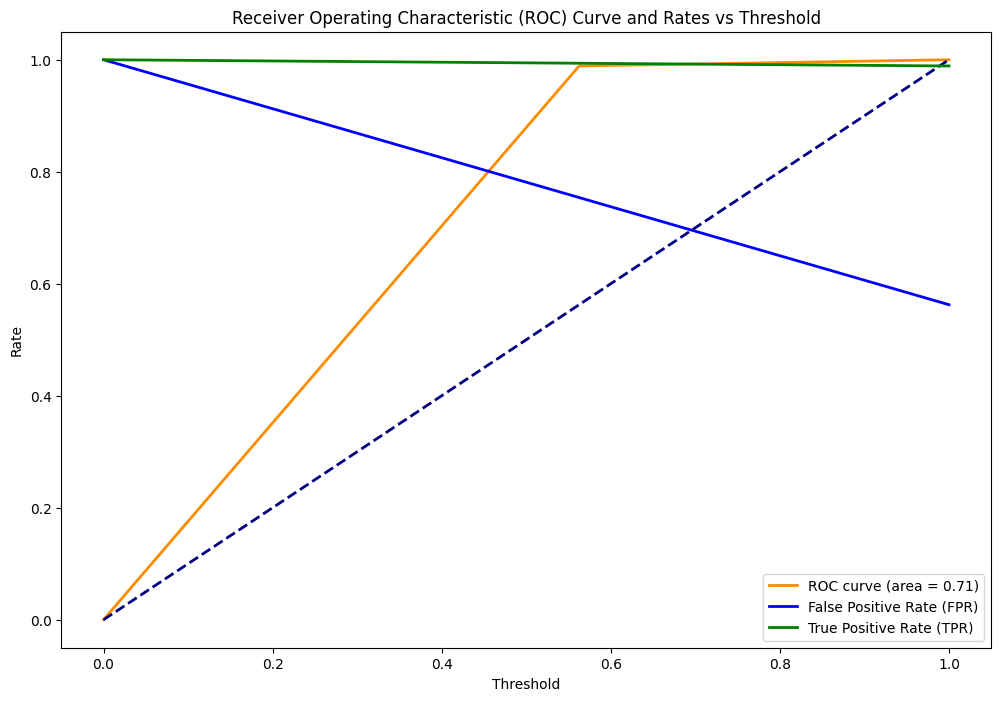

In [61]:
utility.roc_plot(preds, test_labels)

True Negatives: 63
False Positives: 81
False Negatives: 156
True Positives: 13840


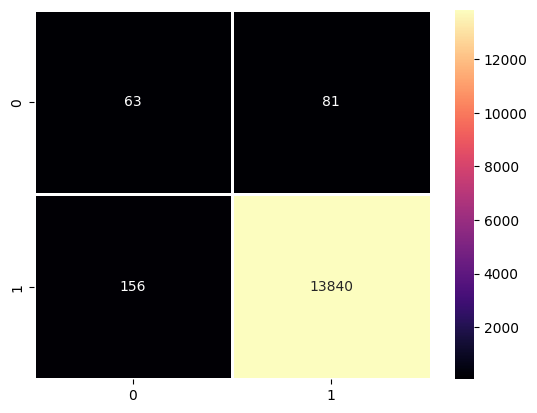

In [62]:
utility.create_heatmap(cm)

In [63]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


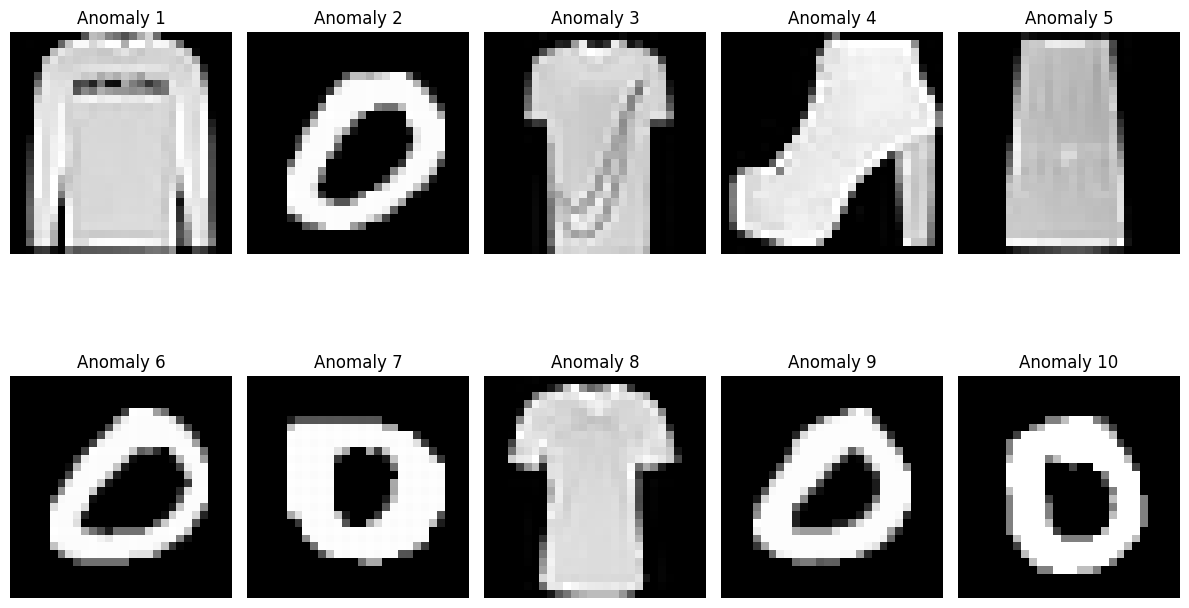

In [64]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data)